# Reversal learning task

Probability ratings will be used to derive both model-free and model-based parameters that will describe the quality of learning

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

import theano
import theano.tensor as tt

In [130]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'
db = pd.DataFrame()

for sub in glob(glober):
    try:
        temp = pd.read_csv(sub)
        temp['sub']= sub.split("_")[2]
        #temp.rating.replace(o, np.nan) 
        temp['CSp'] = temp.rectOri[2]
            
        db = db.append(temp)
    except:
        print(sub)



/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_29_RV/ETLearning_1622744748_29.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_35_RV/ETLearning_1627325520_35.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_27_RV/ETLearning_1621360214_27.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_41_RV/ETLearning_1631717436_41.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_41_RV/ETLearning_1631717499_41.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_42_RV/ETLearning_1632340193_42.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_45_RV/ETLearning_1633453060_45.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_48_RV/ETLearning_1636560777_48.csv
/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_48_RV/ETLearning_1636561503_48.csv


In [133]:
db['rating_clean'] = db.rating_clean.replace(0, np.nan)
fig1 = db[db.rating!=0]

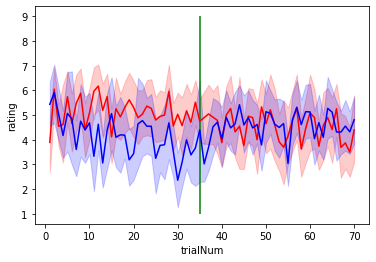

In [134]:
sns.lineplot(x='trialNum',y='rating', data=db[(db.rectOri==db.CSp)], color ='red')
sns.lineplot(x='trialNum',y='rating', data=db[(db.rectOri!=db.CSp)], color='blue')
plt.vlines(x=35, ymin=1, ymax=9, colors='green')

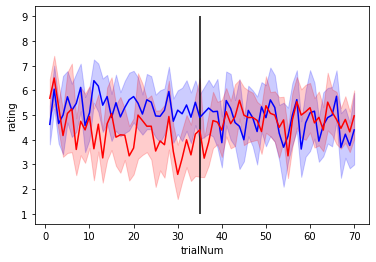

In [142]:
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri==fig1.CSp)], color='blue')
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri!=fig1.CSp)], color='red')
plt.vlines(x=35, ymin=1, ymax=9, colors='black')

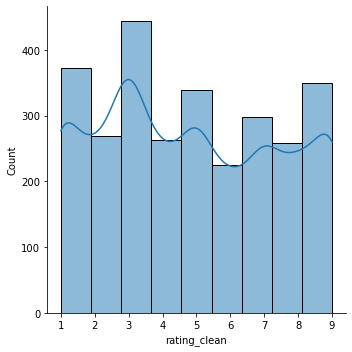

In [146]:
sns.displot(db.rating_clean, kde=True, bins=9)

## Model free analysis

1. Acquisition strength (ACQ) = the difference between the mean ratings of CS+ and CS− in the second half of the acquisition stage (late acquisition)

2. change in rating of CS+ (ΔCS+) between late acquisition and late reversal

3. change in rating of CS- (ΔCS-) between late acquisition and late reversal 


In [143]:
subs = db['sub'].unique()

model_free= pd.DataFrame()

for sub in subs:
    df = db[db['sub'] == sub]
    df = df[df.rectValue == 0].reset_index()
    trials = []
    for i in range(len(df)):
    
        temp = df[:i+1]
        trials.append(len(temp[temp['rectOri']== temp['rectOri'][i]]))

    df['trials'] = trials
    
    
    CSpA = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    CSmA = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])

    CSpR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] > 21)]['rating_clean'])
    CSmR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] > 21)]['rating_clean'])

    ACQ = CSpA - CSmA
    dCSp = CSpA - CSpR 
    dCSm = CSmR - CSmA
    
    temp = pd.DataFrame({'sub':[sub], 'ACQ': [ACQ], 'dCSp':[dCSp], 'dCSm': [dCSm]})
    model_free = model_free.append(temp)

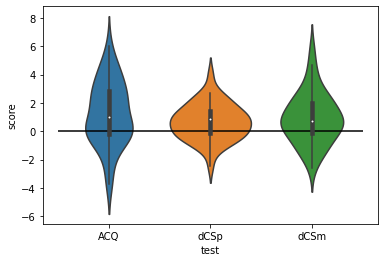

In [144]:
fig2 = pd.melt(model_free, id_vars='sub', value_vars=['ACQ', 'dCSp', 'dCSm'], value_name='score', var_name = 'test')
sns.violinplot(x = 'test', y='score', data=fig2)
plt.hlines(y=0,xmin=-0.5,xmax=2.5, color='black')

## Rescorla-Wagner model 

#### Estimating the learning parameters via Maximum Likelihood

In [167]:
def subject_data(sub_n):

    df = db[db['sub'] == sub_n]
    ratingVec = df['rating_clean'].values
    rewVec = np.zeros(len(ratingVec), dtype=np.int32) # vector to capture Picture (1=yes, 0=no)
    stimVec = np.zeros(len(ratingVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 0= CS-)
    nTrials = len(df) # grab number of trials
    
    for i in range(nTrials):
        if df.rectValue[i] > 0:
            rewVec[i] = 1
        if df.rectOri[i] == df.CSp[i]:
            stimVec[i] = 1
    
    if ((ratingVec.shape == rewVec.shape) & (ratingVec.shape == stimVec.shape)):
        return (nTrials, ratingVec, rewVec, stimVec)
    else:
        print(error in sub)

In [190]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args
    # Initialize values
    Q = np.array([.5, .5])
    log_prob_actions = np.zeros(len(actions))
    
    i=0

    for t, (a, r) in enumerate(zip(actions,rewards)):
    # Apply the softmax transformation
        Q_ = Q * beta
        log_prob_action = Q_ - sp.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]
        # Update the Q values for the next trial
        
        Q[a] = Q[a] + alpha * (r - Q[a])
        # print("iter: {}, Q0= {:0.3f} Q[1]= {:0.3f}".format(i, Q[0], Q[1]))
        #i += 1
    
    # print(f'Alpha is {alpha}')

# Return the negative log likelihood of all observed actions
    return (-np.sum(log_prob_actions[1:]))


In [191]:
nTrials, ratingVec, rewVec, stimVec = subject_data('13')
llik_td([0.5, 0.5], *(stimVec, rewVec))

46.852837915812245

In [ ]:
v = 0.001 # set low value

# for loop over trials and adjust value
dfSub = db
print(dfSub.columns)
dfSub.head()

In [193]:
def update_Q(action, reward,
             Qs,
             alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """       
    Qs = tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [194]:
# Transform the variables into appropriate Theano objects
rewards_ = theano.shared(np.asarray(rewVec, dtype='int16'))
actions_ = theano.shared(np.asarray(stimVec, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * tt.ones(2, dtype='float64')

# Compute the Q values for each trial
Qs, _ = theano.scan(
    fn=update_Q,
    sequences=[actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

# Apply the softmax transformation
Qs_ = Qs * beta
log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# Calculate the negative log likelihod of the observed actions
log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]-1), actions_[1:]]
neg_log_like = -tt.sum(log_prob_actions)

In [195]:
theano_llik_td = theano.function(inputs=[alpha, beta], outputs=neg_log_like)
result = theano_llik_td(0.5, 0.5)
float(result)

46.85283791581223

In [232]:
def theano_llik_td(alpha, intercept, betaCSm, betaCSp, actions, rewards):
    rewards = theano.shared(np.asarray(rewards, dtype='int16'))
    actions = theano.shared(np.asarray(actions, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((2), dtype='float64')
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])
    
        
    # Apply the sotfmax transformation
   # Qs_ = Qs[:-1] * beta
  #  log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)
    scrm = intercept + betaCSm*Qs[:,0]
    scrp = intercept + betaCSp*Qs[:,1]
    # Calculate the negative log likelihod of the observed actions
   # log_prob_actions = log_prob_actions[tt.arange(actions.shape[0]-1), actions[1:]]
    scr=[scrm, scrp]
    return (scr)#[:,0]#Qs[:,1]#tt.sum(log_prob_actions)  # PyMC makes it negative by default

In [239]:
result = theano_llik_td(0.5, 0.5,0.2,0.2, stimVec, rewVec)
result[1].eval()
#plt.plot(result.eval())

array([0.55      , 0.55      , 0.625     , 0.5625    , 0.5625    ,
       0.5625    , 0.63125   , 0.565625  , 0.565625  , 0.6328125 ,
       0.6328125 , 0.56640625, 0.53320312, 0.53320312, 0.51660156,
       0.51660156, 0.60830078, 0.55415039, 0.55415039, 0.5270752 ,
       0.5270752 , 0.5135376 , 0.5135376 , 0.5067688 , 0.6033844 ,
       0.6033844 , 0.6033844 , 0.5516922 , 0.6258461 , 0.6258461 ,
       0.66292305, 0.58146152, 0.58146152, 0.54073076, 0.52036538,
       0.52036538, 0.52036538, 0.51018269, 0.51018269, 0.50509135,
       0.50254567, 0.50254567, 0.50127284, 0.50127284, 0.50127284,
       0.50063642, 0.50063642, 0.50031821, 0.50031821, 0.5001591 ,
       0.5001591 , 0.5001591 , 0.50007955, 0.50007955, 0.50003978,
       0.50003978, 0.50003978, 0.50001989, 0.50001989, 0.50000994,
       0.50000994, 0.50000994, 0.50000497, 0.50000497, 0.50000497,
       0.50000249, 0.50000249, 0.50000124, 0.50000124, 0.50000124])

In [244]:
with pm.Model() as m:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.Normal('beta',0, 10, shape=3)
    eps = pm.HalfCauchy('eps', 10, shape=1)
    #like = pm.Potential('like', theano_llik_td(alpha, beta, stimVec, shockVec))
    #like = pm.Bernoulli('like', theano_llik_td(alpha, beta, stimVec, shockVec))
    mu = theano_llik_td(alpha,beta[0], beta[1], beta[2], stimVec, rewVec)
    sc = pm.Normal('scr_hat', mu, eps, observed=ratingVec, shape = 2)
    tr = pm.sample(target_accept=.95)


ValueError: setting an array element with a sequence.

Got error No model on context stack. trying to find log_likelihood in translation.
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

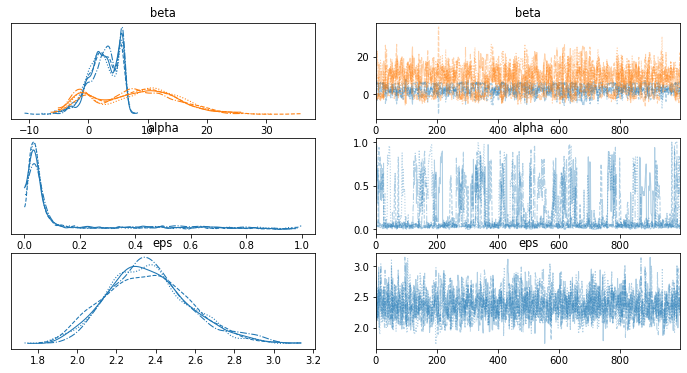

In [217]:
az.plot_trace(az.from_pymc3(tr))

In [216]:
az.summary(az.from_pymc3(tr))

Got error No model on context stack. trying to find log_likelihood in translation.
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.659,2.553,-1.790,6.523,0.106,0.084,554.0,1234.0,1.0
beta[1],7.836,6.802,-3.730,18.952,0.298,0.211,543.0,1238.0,1.0
alpha,0.153,0.229,0.001,0.684,0.012,0.008,486.0,855.0,1.0
eps[0],2.366,0.213,1.954,2.755,0.006,0.004,1314.0,1652.0,1.0


In [ ]:
az.plot_pair(az.from_pymc3(tr), var_names=['alpha', 'beta'], divergences=True)

In [ ]:

#rn = was US delivered (1 for US, 0 for no US).
#Vn(x) = value predictions
#δn = rn – Vn(xn) = prediction error
#Vn+1(Xn) = Vn(Xn)+αδn

rn = rewVec
Vcsp = [0.0001]
Vcsm = [0.001]
g = np.zeros(len(ratingVec), dtype=np.int32)
α = np.mean(tr.alpha)

for i in range(1,len(db)):
    if db.rectOri[i] == CSplus:
        g[i] = rn[i]-Vcsp[-1]
        Vcsp.append(Vcsp[-1]+α*g[-1])
    else:
        g[i] =rn[i]-Vcsm[-1]
        Vcsm.append(Vcsm[-1]+α*g[i])
    

In [ ]:
np.mean(tr.alpha)